# 加载数据

In [1]:
import pandas as pd

In [2]:
!pwd

/cpfs01/user/lvhongxia/ML-NN-final/problem5_email_classify


In [3]:
file_path = "/cpfs01/user/lvhongxia/ML-NN-final/problem5_email_classify/enron_spam_data/enron_spam_data.csv"

In [4]:
data = pd.read_csv(file_path, encoding='utf-8')

In [5]:
data['Message'][1]

'gary , production from the high island larger block a - 1 # 2 commenced on\nsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and\n10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .\ngeorge x 3 - 6992\n- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\ndaren j farmer\n12 / 10 / 99 10 : 38 am\nto : carlos j rodriguez / hou / ect @ ect\ncc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ect\nsubject : vastar resources , inc .\ncarlos ,\nplease call linda and get everything set up .\ni \' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase each\nfollowing day based on my conversations with bill fischer at bmar .\nd .\n- - - - - - - - - - - - - - - - - - - - - - forwarded by daren j farmer / hou / ect on 12 / 10 / 99 10 : 34\nam - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [6]:
data

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14
...,...,...,...,...,...
33711,33711,= ? iso - 8859 - 1 ? q ? good _ news _ c = eda...,"hello , welcome to gigapharm onlinne shop .\np...",spam,2005-07-29
33712,33712,all prescript medicines are on special . to be...,i got it earlier than expected and it was wrap...,spam,2005-07-29
33713,33713,the next generation online pharmacy .,are you ready to rock on ? let the man in you ...,spam,2005-07-30
33714,33714,bloow in 5 - 10 times the time,learn how to last 5 - 10 times longer in\nbed ...,spam,2005-07-30


# 模型训练

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm  

# 合并 'Subject' 和 'Message' 两列为 'Content' 列
data['Content'] = data['Subject'].fillna('') + ' ' + data['Message'].fillna('')

# 标签编码，将 'Spam/Ham' 转换为二进制标签（0 或 1）
label_encoder = LabelEncoder()
data['Spam/Ham'] = label_encoder.fit_transform(data['Spam/Ham'])

# 提取特征 (X) 和标签 (y)
X = data['Content']
y = data['Spam/Ham']

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 使用 TF-IDF 对文本进行向量化
# 将文本数据转换为数值特征
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 1), sublinear_tf=True, use_idf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 训练 LDA 模型
lda = LatentDirichletAllocation(
    n_components=20,              # 设置主题数
    learning_method='batch',      # 使用批量学习方法
    max_iter=50,                  # 设置最大迭代次数
    learning_decay=0.7,           # 设置学习衰减率
    learning_offset=10,           # 设置学习偏移量
    random_state=42,              # 固定随机种子
    n_jobs=-1                     # 使用所有核心进行并行计算
)

# 使用 LDA 模型提取训练和测试集的主题特征
with tqdm(total=1, desc="Training LDA", ncols=100) as pbar:
    lda.fit(X_train_tfidf)  
    pbar.update(1)  

X_train_lda = lda.transform(X_train_tfidf)
X_test_lda = lda.transform(X_test_tfidf)

# 训练逻辑回归模型进行分类
classifier = LogisticRegression(random_state=42, max_iter=1000)

with tqdm(total=1, desc="Training Logistic Regression", ncols=100) as pbar:
    classifier.fit(X_train_lda, y_train)  
    pbar.update(1)  

# 评估模型
y_pred = classifier.predict(X_test_lda)

# 生成分类报告
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("分类报告:")
print(report)

Training Logistic Regression: 100%|███████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]

分类报告:
              precision    recall  f1-score   support

         ham       0.96      0.96      0.96      3309
        spam       0.96      0.96      0.96      3435

    accuracy                           0.96      6744
   macro avg       0.96      0.96      0.96      6744
weighted avg       0.96      0.96      0.96      6744



# 结果分析

## 混淆矩阵

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3xwll2zy because the default path (/home/lvhongxia/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


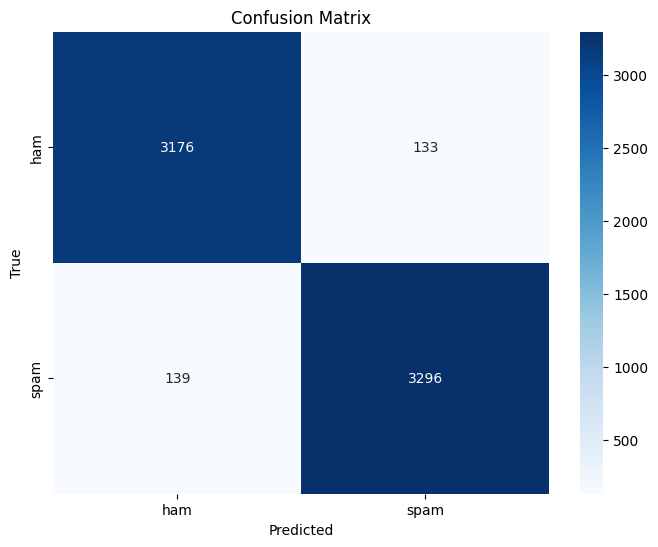

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## ROC曲线与AUC

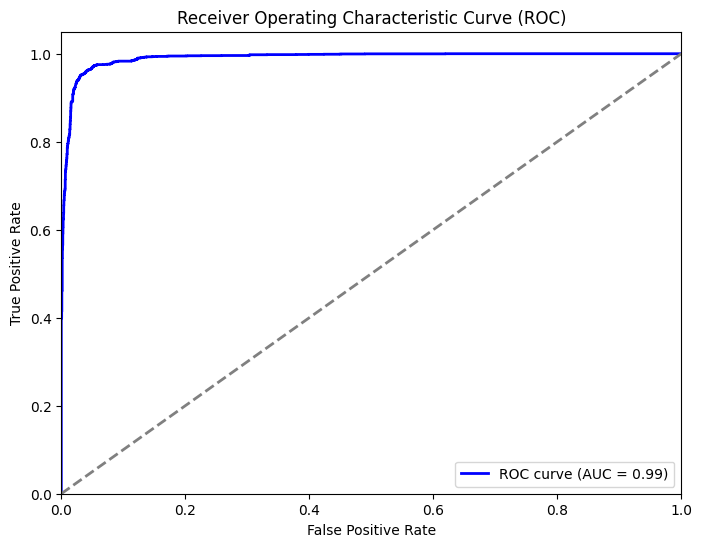

In [11]:
from sklearn.metrics import roc_curve, auc

# 计算预测的概率
y_prob = classifier.predict_proba(X_test_lda)[:, 1]

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

## 主题模型分析

In [13]:
import numpy as np

# 获取LDA模型的主题-词分布
n_words = 10  # 每个主题显示前10个词
words = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    top_words_idx = topic.argsort()[-n_words:][::-1]
    top_words = [words[i] for i in top_words_idx]
    print(" ".join(top_words))

Topic 0:
com email http click free www receive money mail account
Topic 1:
xls attached hpl file nom 2000 2001 article ur noms
Topic 2:
ect vince enron hou subject cc kaminski pm 2000 thanks
Topic 3:
enron power gas new energy market business trading group risk
Topic 4:
hourahead schedule dbcaps 97 database manual alias unknown failed failure
Topic 5:
hourahead schedules hour date start detected variances ancillary txt final
Topic 6:
713 attached louise message original sent enron 853 weekly fw
Topic 7:
meter deal ect daren 2000 hou gas enron cc thanks
Topic 8:
congratulations promotion tw gift et card michelle lokay fw survey
Topic 9:
http mortgage penis rate www com php loan credit tabs
Topic 10:
software xp windows adobe 95 professional microsoft 2004 office softwares
Topic 11:
statements company investment securities stock report stocks act advice news
Topic 12:
logo stationery business image competitors design custom identity company life
Topic 13:
viagra online prescription http 

# 消融实验

Testing different topic numbers: 100%|██████████| 4/4 [01:33<00:00, 23.28s/it]


   n_topics  accuracy       auc  f1_score
0         5  0.948547  0.987883  0.949630
1        10  0.946916  0.983552  0.948711
2        20  0.959668  0.990765  0.960373
3        50  0.946916  0.985662  0.947198


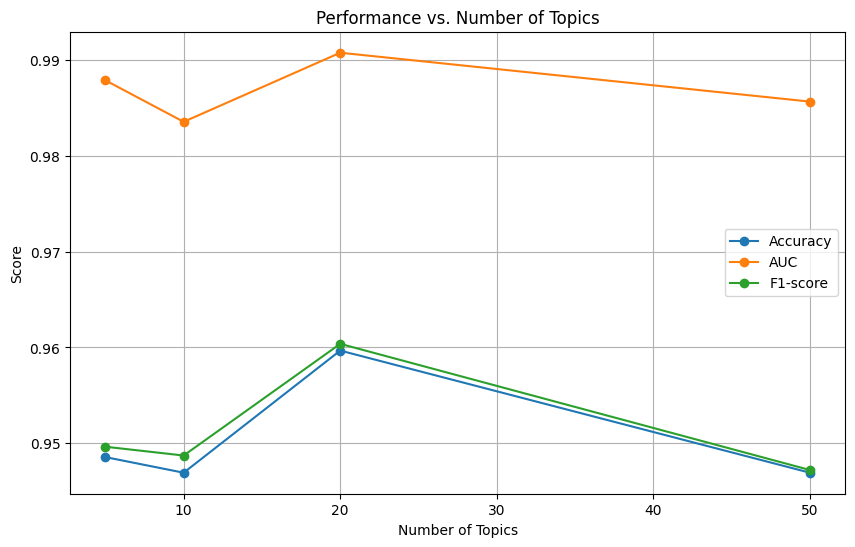

In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from tqdm import tqdm  # 显示进度条
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_csv(file_path)

# 数据预处理
data['Content'] = data['Subject'].fillna('') + ' ' + data['Message'].fillna('')
label_encoder = LabelEncoder()
data['Spam/Ham'] = label_encoder.fit_transform(data['Spam/Ham'])
X = data['Content']
y = data['Spam/Ham']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF 向量化
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english', ngram_range=(1, 1), sublinear_tf=True, use_idf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 定义不同的主题数
topic_numbers = [5, 10, 20, 50]
results = []  # 存储结果

# 遍历不同的主题数
for n_topics in tqdm(topic_numbers, desc="Testing different topic numbers"):
    # 1. 训练 LDA 模型
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method='batch',
        max_iter=50,
        learning_decay=0.7,
        learning_offset=10,
        random_state=42,
        n_jobs=-1
    )
    lda.fit(X_train_tfidf)
    
    # 提取 LDA 特征
    X_train_lda = lda.transform(X_train_tfidf)
    X_test_lda = lda.transform(X_test_tfidf)
    
    # 2. 训练逻辑回归分类器
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    classifier.fit(X_train_lda, y_train)
    
    # 3. 评估分类性能
    y_pred = classifier.predict(X_test_lda)
    y_prob = classifier.predict_proba(X_test_lda)[:, 1]  # 获取预测概率
    
    # 计算指标
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    # 存储结果
    results.append({
        "n_topics": n_topics,
        "accuracy": acc,
        "auc": auc,
        "f1_score": f1
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果
print(results_df)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_topics'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['n_topics'], results_df['auc'], marker='o', label='AUC')
plt.plot(results_df['n_topics'], results_df['f1_score'], marker='o', label='F1-score')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.title('Performance vs. Number of Topics')
plt.legend()
plt.grid()
plt.show()